# Analisis de la movilidad urbana utilizando estadisticas del Comoir

En este notebook intento realizar un analisis geoespacial de la movilidad urbana utilizando como fuente de datos las estadisticas de uso de la aplicacion Comoir publicadas por la IMM.

Primero lo primero - Los import!

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import shapely
from pyproj import Proj, transform

%matplotlib inline

sns.set(style="whitegrid")

inProj = Proj(init='epsg:31981')
outProj = Proj(init='epsg:4326')

Algunas referencias a los archivos shapefile y csv para luego poder cargar los que realmetne necesito. Al momento de empezar con el notebook no tengo ni idea de cuales me van a servir y cuales no. Bueno, en realidad se que los csv con las estadisticas de las consultas realizadas por los usuarios los preciso, sino para que estoy haciendo esto?

In [10]:
barrios_shp_path = 'barrios/barrios.shp' #shapefile con los barrios de montevideo
vias_shp_path = 'v_mdg_vias/v_mdg_vias.shp' #shapefile con las vias (calles, caminos, pasajes, etc.) de mvdeo
destino_shp_path = 'v_uptu_lsv_destinos/v_uptu_lsv_destinos.shp' #shapefile con los destino... ni se porque lo baje
ejes_shp_path = 'ejesinv/ejesinv.shp' # ejes de las calles. Tiene todas llas "cuadras" de cada calle.
codpost_shp_path = 'cpost/cpost.shp' # poligonos de los distintos codigos postales de montevideo 

manzanas_shp_path = 'v_mdg_manzanas/v_mdg_manzanas.shp' #shapefile con las manzanas
accesos_shp_path = 'v_mdg_accesos/v_mdg_accesos.shp' #shapefile con las calles y su numeracion. 
cultura_csv_path = 'v_uptu_lugares/uptu_cultura.csv.gz' #shapefile con la ubicacion de los centros culturales
deporte_csv_path = 'v_uptu_lugares/uptu_deporte.csv.gz' #shapefile con los lugares centros deportivos
educacion_csv_path = 'v_uptu_lugares/uptu_educacion.csv.gz' #shapefile con los centros educativos 
patrimonio_csv_path = 'v_uptu_lugares/uptu_patrimonio.csv.gz' #shapefile con los lugares patrimoniales
playa_csv_path = 'v_uptu_lugares/uptu_playa.csv.gz' #shapefile con las playas
salud_csv_path = 'v_uptu_lugares/uptu_salud.csv.gz' #shapefile con los centros de salud
espacios_shp_path = 'v_mdg_espacios_libres/v_mdg_espacios_libres.shp' #shapefile de espacios libres (parques, plazas, etc)
monumentos_shp_path = 'v_mdg_ubicaciones_notables/v_mdg_ubicaciones_notables.shp' #shapefile de monumentos

Los datos con las estadisticas estan separados en 1 archivo por año. Del 2010 al 2013 inclusive, contienen la información todo el año, mientras que el 2014 solo incluye información del primer semestre de ese año. Las busquedas que se pueden hacer en Comoir son de 3 tipos por cada punto del recorrido (origen y destino) lo que da un total de 6 tipos diferentes combinados. Las busquedas pueden hacerse por:
    - Esquina: curce de calles
    - Dirección: calle y número
    - Lugar de interés

Cada csv indica el tipo de origen, el tipo de destino, y para cada uno de ellos se indica 1 o 2 códigos. Si el tipo del punto es dirección o lugar de interes, el código identifica la calle o el lugar de interes respectivamente. Si el tipo del punto es esquina, se indican dos codigos, donde el primero identifica una calle y el segundo la otra. Los códigos hacen referencia a los otros shapefile, para las calles se hace referencia a ejes_shp_path, y para lugares de interes se hace referencia a cultura_shp_path, deporte_shp_path, educacion_shp_path, patrimonio_shp_path, playa_shp_path, salud_shp_path, espacios_shp_path y monumentos_shp_path. Para las direcciones numeradas (calle y numero de puerta) se hace referencia al shapefile accesos_shp_path.

In [11]:
r2010_csv_path = 'comoir/comoir_2010_1.csv.gz'
r2011_csv_path = 'comoir/comoir_2011_1.csv.gz'
r2012_csv_path = 'comoir/comoir_2012_1.csv.gz' 
r2013_csv_path = 'comoir/comoir_2013_1.csv.gz'
r2014_csv_path = 'comoir/comoir_2014_1.csv.gz'

In [12]:
#Levanto los lugares de interes y agrego a cada dataframe el tipo y las coordenadas (x,y)
cu = pd.read_csv(cultura_csv_path)      #cultura         - tipo 3
de = pd.read_csv(deporte_csv_path)      #deporte         - tipo 4
ed = pd.read_csv(educacion_csv_path)    #educacion       - tipo 5
pa = pd.read_csv(patrimonio_csv_path)   #patrimonio      - tipo 9
pl = pd.read_csv(playa_csv_path)        #playa           - tipo 10
sa = pd.read_csv(salud_csv_path)        #salud           - tipo 11
el = gpd.read_file(espacios_shp_path)   #espacios libres - tipo 6 espacio libre
pq = el[np.isfinite(el['COD_NOM_PA'])]  #parques         - tipo 7
el = el[np.isfinite(el['COD_NOM_ES'])]  #espacio libre   - tipo 6
mo = gpd.read_file(monumentos_shp_path) #monumentos      - tipo 8

cu.loc[:,'tipo'] = 3
de.loc[:,'tipo'] = 4
ed.loc[:,'tipo'] = 5
pa.loc[:,'tipo'] = 9
pl.loc[:,'tipo'] = 10
sa.loc[:,'tipo'] = 11
el.loc[:,'tipo'] = 6
el.loc[:,'codigo'] = el['COD_NOM_ES'].apply(lambda c: c)
el.loc[:,'x'] = el['geometry'].apply(lambda p: p.centroid.x)
el.loc[:,'y'] = el['geometry'].apply(lambda p: p.centroid.y)
pq.loc[:,'tipo'] = 7
pq.loc[:,'codigo'] = pq['COD_NOM_PA'].apply(lambda c: c)
pq.loc[:,'x'] = pq['geometry'].apply(lambda p: p.centroid.x)
pq.loc[:,'y'] = pq['geometry'].apply(lambda p: p.centroid.y)
mo.loc[:,'x'] = mo['geometry'].apply(lambda p: p.x)
mo.loc[:,'y'] = mo['geometry'].apply(lambda p: p.y)
mo = mo.dropna(subset=['COD_NOM_UB'])
mo.loc[:,'tipo'] = 8
mo.loc[:,'codigo'] = mo['COD_NOM_UB'].apply(lambda c: c)

In [13]:
#Uno todos los lugares de interes en un solo dataframe con el codigo, tipo y las coordenadas (x,y) de cada uno.
lugares_interes = cu.append(de.append(ed.append(pa.append(pl.append(sa.append(pq.append(el.append(mo,ignore_index=True),
                                                                              ignore_index=True),
                                                                    ignore_index=True),
                                                          ignore_index=True),
                                                ignore_index=True),
                                      ignore_index=True), 
                            ignore_index=True), 
                  ignore_index=True)
lugares_interes = lugares_interes[['codigo', 'tipo', 'x', 'y']]

In [14]:
del cu, de, ed, pa, pl, sa, el, pq, mo

In [15]:
#Levanto las "cuadras" de cada calle y las agrupo por codigo para luego unir todas las cuadras de cada calle en una sola coleccion
ejes = gpd.read_file(ejes_shp_path) 
calles = ejes.groupby('CODIGO')['geometry'].agg({'geometry': lambda x: shapely.ops.linemerge(x.values)})
calles.loc[:,'codigo'] = calles.index
calles.loc[:,'tipo'] = 1

In [16]:
#Levanto las calles con su numeracion
c_nums = gpd.read_file(accesos_shp_path) 
c_nums.loc[:,'direccion'] = c_nums['NOM_CALLE'] + ' ' + c_nums['NUM_PUERTA'].map(str)
c_nums.loc[:,'x'] = c_nums['geometry'].apply(lambda p: p.x)
c_nums.loc[:,'y'] = c_nums['geometry'].apply(lambda p: p.y)
c_nums.loc[:,'tipo'] = 2
dirs = c_nums[['COD_NOMBRE', 'tipo', 'direccion','x','y']] #para cada direccion posible tengo las coordenadas (x,y).

In [17]:
#Levanto las consultas realizadas en la aplicacion del 2010 al 2014.
#r2010 = pd.read_csv(r2010_csv_path, low_memory=False)
cir_data = pd.read_csv(r2010_csv_path, low_memory=False)
#r2012 = pd.read_csv(r2012_csv_path, low_memory=False)
#r2013 = pd.read_csv(r2013_csv_path, low_memory=False)
#r2014 = pd.read_csv(r2014_csv_path, low_memory=False)

In [18]:
cir_data.count()
#Unifico en un solo lugar toda la info.
#cir_data = r2010.append(r2011.append(r2012.append(r2013.append(r2014,
#                                                               ignore_index=True),
#                                                  ignore_index=True),
#                                     ignore_index=True),
#                        ignore_index=True)

id                  236094
sesion              236094
fecha               236094
tipo_viaje          236094
tipo_origen         236094
codigo_origen_1     236094
codigo_origen_2     230597
desc_origen         236094
tipo_destino        236094
codigo_destino_1    236094
codigo_destino_2    222818
desc_destino        236094
distancia           236094
es_combinacion      192528
radio_max           192528
largo_resp          192528
tiempo              236094
es_dd_origen             0
es_dd_destino            0
dtype: int64

In [19]:
#Ya tengo los datos de las consultas de los usuarios (datafram cir_data)
#y por otro lado tengo, en un formato u otro, las coordenadas de cada lugar de montevideo.
#Ahora solo tengo que unirlos; primero los origenes y luego los destino.
o_li = cir_data.merge(lugares_interes, left_on=['codigo_origen_1', 'tipo_origen'], 
                      right_on=['codigo', 'tipo'], how='inner')
o_li = o_li.drop_duplicates(subset=['id'], keep='first')

In [20]:
o_cc = cir_data.merge(calles, left_on=['codigo_origen_1', 'tipo_origen'], 
                      right_on=['codigo', 'tipo'], how='inner')\
                 .merge(calles, left_on=['codigo_origen_2', 'tipo_origen'], 
                        right_on=['codigo', 'tipo'], how='inner')
o_cc = o_cc.drop_duplicates(subset=['id'], keep='first')

In [21]:
cd = cir_data[cir_data['tipo_origen'] == 2]
dd = dirs[dirs.isin(cd['codigo_origen_1'].values)['COD_NOMBRE']]
dd = dd[dd.isin(cd['desc_origen'].values)['direccion']]

In [22]:
o_cn = cd.merge(dd, left_on=['codigo_origen_1', 'tipo_origen'], 
                      right_on=['COD_NOMBRE', 'tipo'], how='inner')
o_cn = o_cn.query('desc_origen==direccion')
o_cn = o_cn.drop_duplicates(subset=['id'], keep='first')

In [23]:
d_li = cir_data.merge(lugares_interes, left_on=['codigo_destino_1', 'tipo_destino'], 
                      right_on=['codigo', 'tipo'], how='inner')
d_li = d_li.drop_duplicates(subset=['id'], keep='first')

d_cc = cir_data.merge(calles, left_on=['codigo_destino_1', 'tipo_destino'], 
                      right_on=['codigo', 'tipo'], how='inner')\
                 .merge(calles, left_on=['codigo_destino_2', 'tipo_destino'], 
                        right_on=['codigo', 'tipo'], how='inner')
d_cc = d_cc.drop_duplicates(subset=['id'], keep='first')

In [24]:
cd = cir_data[cir_data['tipo_destino'] == 2]
dd = dirs[dirs.isin(cd['codigo_destino_2'].values)['COD_NOMBRE']]
dd = dd[dd.isin(cd['desc_destino'].values)['direccion']]

In [26]:
d_cn = cir_data.merge(dd, left_on=['codigo_destino_1', 'tipo_destino'], 
                      right_on=['COD_NOMBRE', 'tipo'], how='inner')
d_cn = d_cn.query('desc_destino==direccion')
d_cn = d_cn.drop_duplicates(subset=['id'], keep='first')

In [27]:
o_li = o_li[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'x', 'y']]
o_li = o_li.rename(columns={'x': 'x_o', 'y': 'y_o'})

o_cn = o_cn[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'x', 'y']]
o_cn = o_cn.rename(columns={'x': 'x_o', 'y': 'y_o'})

o_cc = o_cc[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'geometry_x', 'geometry_y']]
o_cc = o_cc.rename(columns={'geometry_x': 'geometry_o1', 'geometry_y': 'geometry_o2'})

d_li = d_li[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'x', 'y']]
d_li = d_li.rename(columns={'x': 'x_d', 'y': 'y_d'})

d_cn = d_cn[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'x', 'y']]
d_cn = d_cn.rename(columns={'x': 'x_d', 'y': 'y_d'})

d_cc = d_cc[['id', 'sesion', 'tipo_origen', 'codigo_origen_1', 'codigo_origen_2', 'desc_origen', 
             'tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'geometry_x', 'geometry_y']]
d_cc = d_cc.rename(columns={'geometry_x': 'geometry_d1', 'geometry_y': 'geometry_d2'})

In [28]:
d_cc.loc[:,'punto_d'] = d_cc.apply(lambda row: row.geometry_d1.intersection(row.geometry_d2), axis=1)
o_cc.loc[:,'punto_o'] = o_cc.apply(lambda row: row.geometry_o1.intersection(row.geometry_o2), axis=1)

In [29]:
def get_xy(punto, coord):
    if isinstance(punto, float):
        return punto
    elif isinstance(punto, shapely.geometry.Point):
        return punto.xy[coord][0]
    elif isinstance(punto, shapely.geometry.MultiPoint):
        return punto[0].xy[coord][0]
    elif punto.is_empty:
        return pd.np.nan

In [31]:
d_cc.loc[:,'x_d'] = d_cc['punto_d'].apply(lambda p: get_xy(p,0))
d_cc.loc[:,'y_d'] = d_cc['punto_d'].apply(lambda p: get_xy(p,1))
d_cc = d_cc.dropna(subset=['x_d'])

o_cc.loc[:,'x_o'] = o_cc['punto_o'].apply(lambda p: get_xy(p,0))
o_cc.loc[:,'y_o'] = o_cc['punto_o'].apply(lambda p: get_xy(p,1))
o_cc = o_cc.dropna(subset=['x_o'])

In [32]:
origenes = o_li.append(o_cn.append(o_cc, ignore_index=True), ignore_index=True)
destinos = d_li.append(d_cn.append(d_cc, ignore_index=True), ignore_index=True)

In [33]:
origenes['geometry'] = origenes[['x_o', 'y_o']].apply(shapely.geometry.Point, axis=1)
destinos['geometry'] = destinos[['x_d', 'y_d']].apply(shapely.geometry.Point, axis=1)

In [34]:
origenes = origenes.drop(['geometry_o1','geometry_o2','punto_o'], axis=1)
destinos = destinos.drop(['geometry_d1','geometry_d2','punto_d'], axis=1)

In [35]:
origenes['codigo_origen_1'].fillna(value=-1,inplace=True)
origenes['codigo_origen_2'].fillna(value=-1,inplace=True)
destinos['codigo_destino_1'].fillna(value=-1,inplace=True)
destinos['codigo_destino_2'].fillna(value=-1,inplace=True)

In [36]:
cpost = gpd.read_file(codpost_shp_path)

In [37]:
barrios = gpd.read_file(barrios_shp_path)
barrios.index = barrios.NROBARRIO

In [38]:
dist_origs = origenes.drop_duplicates(subset=['x_o','y_o'], keep='first')[['x_o','y_o']]
dist_dest = destinos.drop_duplicates(subset=['x_d','y_d'], keep='first')[['x_d','y_d']]
gos = gpd.GeoDataFrame(origenes, crs={'init': 'epsg:31981'}, geometry='geometry')
gds = gpd.GeoDataFrame(destinos, crs={'init': 'epsg:31981'}, geometry='geometry')

In [39]:
#gos = gos.rename(columns={'punto_o':'geometry'})
#gds = gds.rename(columns={'punto_d':'geometry'})

In [40]:
from geopandas.tools import sjoin
barrios.crs = crs={'init': 'epsg:31981'}
destsEnBarrios = sjoin(barrios, gds, how='left')

In [41]:
barrios.loc[:,'Busquedas'] = destsEnBarrios.groupby('NROBARRIO').size()

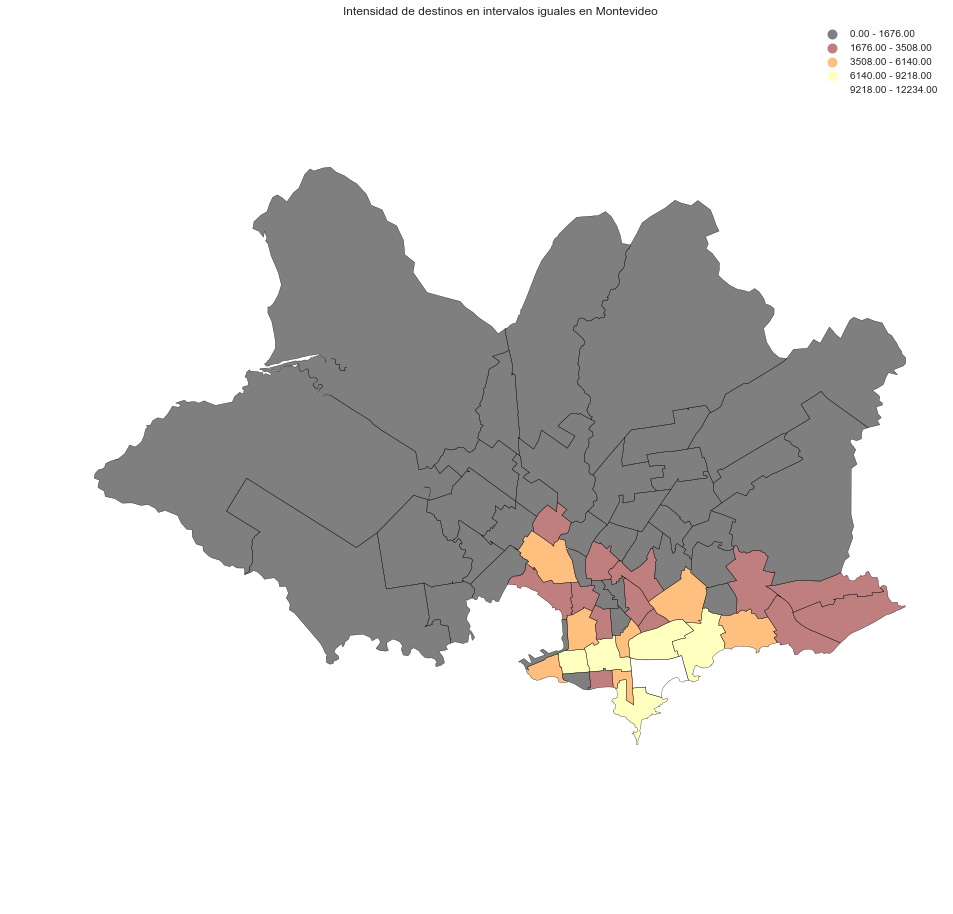

In [42]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(16, 16))
# Plot the equal interval choropleth and add a legend
barrios.plot(column='Busquedas', scheme='fisher_jenks', legend=True, \
           ax=ax, cmap='afmhot', linewidth=0.3)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Intensidad de destinos en intervalos iguales en Montevideo")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

En ***dist_dest*** y ***dist_origs*** tengo las coordenadas de los diferentes origenes y destinos consultados por los usuarios. Ahora deberia tomar esos puntos y hacer lo siguiente:
* Plotear los barrios de montevideo en algun color base que no moleste a los capas superiores
* Plotear los origenes en algun color que contraste bien con el fondo
* Plotear los destinos en algun color que contraste bien con el fondo
* Plotear en una cuarta capa la cantidad de puntos referenciando destinos que contiene cada poligono para dar una idea de la intensidad de las busquedas. Esto seria el mapa de calor

In [43]:
#['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
#['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
b2010 = np.array(barrios.Busquedas)
bins_q5 = ps.Quantiles(b2010, k=7)
colors5 = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
colors = [colors5[i] for i in bins_q5.yb]

In [44]:
def gpd_bokeh(df):
    """Convert geometries from geopandas to bokeh format"""
    nan = float('nan')
    lons = []
    lats = []
    for i,shape in enumerate(df.geometry.values):
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)
                
        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 

    return lons,lats

In [45]:
lons, lats = gpd_bokeh(barrios)

In [46]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource

In [47]:
source = ColumnDataSource(data=dict(
        x=lons,
        y=lats,
        color=colors,
        name=barrios.BARRIO,
        rate=b2010
    ))

TOOLS = "pan, wheel_zoom, box_zoom, reset, hover, save"
p = figure(title="Movilidad Urbana Como Ir (2010)", tools=TOOLS,
          plot_width=900, plot_height=600)

p.patches('x', 'y', source=source,
         fill_color='color', fill_alpha=0.7,
         line_color='white', line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [
    ("Barrio", "@name"),
    ("Busquedas", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]


output_file("comoir2010.html", title="comoir2010.py example")
show(p)